In [1]:
%matplotlib inline


# Utilities for writing h5USID files

**Suhas Somnath**

4/18/2018

**This document illustrates the many handy functions in pyUSID.hdf_utils that significantly simplify writing data
and information into Universal Spectroscopy and Imaging Data (USID) HDF5 files (h5USID files)**


<span style="color:red">**Note**: Most of the functions demonstrated in this notebook have been moved out of ``pyUSID.hdf_utils`` and into ``sidpy.hdf``</span>
<br>
## Introduction
The USID model uses a data-centric approach to data analysis and processing meaning that results from all data analysis
and processing are written to the same h5 file that contains the recorded measurements. The Hierarchical Data Format
(HDF5) allows data, whether it is raw measured data or results of analysis, to be stored in multiple datasets within
the same file in a tree-like manner. Certain rules and considerations have been made in pyUSID to ensure
consistent and easy access to any data.

The h5py python package provides great functions to create, read, and manage data in HDF5 files. In
``pyUSID.hdf_utils``, we have added functions that facilitate scientifically relevant, or pyUSID specific
functionality such as easy creation of USID Main datasets, creation of automatically indexed groups to hold
results of an analysis, etc. Due to the wide breadth of the functions in ``hdf_utils``, the guide for hdf_utils will be
split in two parts - one that focuses on functions that facilitate reading and one that facilitate writing of data.
The following guide provides examples of how, and more importantly when, to use functions in pyUSID.hdf_utils for
various scenarios starting from recording data from instruments to storing analysis data.

## Recommended pre-requisite reading
* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)
* [Crash course on HDF5 and h5py](./h5py_primer.html)
* Utilities for [reading](./hdf_utils_read.html) h5USID files using pyUSID


## Import all necessary packages
Before we begin demonstrating the numerous functions in pyUSID.hdf_utils, we need to import the necessary
packages. Here are a list of packages besides pyUSID that will be used in this example:

* ``h5py`` - to open and close the file
* ``numpy`` - for numerical operations on arrays in memory
* ``matplotlib`` - basic visualization of data



In [2]:
from __future__ import print_function, division, unicode_literals
import subprocess
import sys
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])

import os
# Warning package in case something goes wrong
from warnings import warn
import h5py
import numpy as np
import matplotlib.pyplot as plt

# import sidpy - supporting package for pyUSID:
try:
    import sidpy
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    import sidpy

# Finally import pyUSID:
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

### Create a HDF5 file
We will be using the h5py functionality to do basic operations on HDF5 files



In [3]:
file_path = 'test.h5'
h5_file = h5py.File(file_path, mode='w')

## HDF_Utils works with (and uses) h5py

``sidpy`` and ``hdf_utils`` do not preclude the creation of groups and datasets using the ``h5py`` package. However, the
many functions in ``hdf_utils`` are present to make it easier to handle the reading and writing of multidimensional
scientific data formatted according to the USID model.

We can always use the ``h5py`` functionality to **create a HDF5 group** as shown below:



In [4]:
h5_some_group = h5_file.create_group('Some_Group')
print(h5_some_group)

<HDF5 group "/Some_Group" (0 members)>


In the same way, we can also continue to **create HDF5 datasets** using h5py:



In [5]:
h5_some_dataset = h5_some_group.create_dataset('Some_Dataset', np.arange(5))
print(h5_some_dataset)

<HDF5 dataset "Some_Dataset": shape (0, 1, 2, 3, 4), type "<f4">


### Create Groups
create_indexed_group()
----------------------
In order to accommodate the iterative nature of data recording (multiple sequential and related measurements) and
analysis (same analysis performed with different parameters) we add an index as a suffix to HDF5 Group names.

Let us first create a HDF5 group to store some data recorded from an instrument. The below function will automatically
create a group with an index as a suffix and write certain book-keeping attributes to the group. We will see how this
and similar functions handle situations when similarly named groups already exist.



In [6]:
h5_meas_group = sidpy.prov_utils.create_indexed_group(h5_file, 'Measurement')
print(h5_meas_group)

<HDF5 group "/Measurement_000" (0 members)>


Since there were no other groups whose name started with ``Measurement``, the function assigned the lowest index - ``000``
as a suffix to the requested group name.
Note that the ``-`` character is not allowed in the names of the groups since it will be used as the separator character
in other functions. This will be made clear when discussing the ``create_results_group()`` function later.

``create_indexed_group()`` calls another handy function called ``assign_group_index(`` to get the suffix before creating a
HDF5 group. Should we want to create another new indexed group called ``Measurement``, ``assign_group_index()`` will
notice that a group named ``Measurement_000`` already exists and will assign the next index (``001``) to the new group -
see below. Note that ``assign_group_index()`` does not create the group; it only assigns a non-conflicting string name
for the group.



In [7]:
print(sidpy.prov_utils.assign_group_index(h5_file, 'Measurement'))

Measurement_001


Now lets look at datasets and groups in the created file:



In [8]:
print('Contents within the file so far:')
sidpy.hdf_utils.print_tree(h5_file)

Contents within the file so far:
/
├ Measurement_000
  ---------------
├ Some_Group
  ----------
  ├ Some_Dataset


Clearly, we have the ``Measurement_000`` Group at the same level as a group named ``Some_Group``. The group ``Some_Group``
contains a dataset named ``Some_Dataset`` under it.

Both, ``Measurement_000`` and ``Some_Group`` have an underline below their name to indicate that they are groups unlike
the ``Some_Dataset`` Dataset

### Writing attributes
HDF5 datasets and groups can also store metadata such as experimental parameters. These metadata can be text,
numbers, small lists of numbers or text etc. These metadata can be very important for understanding the datasets
and guide the analysis routines.

While one could use the basic h5py functionality to write and access attributes, one would encounter a lot of problems
when attempting to encode or decode attributes whose values were strings or lists of strings due to some issues in
h5py. This problem has been demonstrated in our
`primer to HDF5 <../beginner/plot_h5py.html>`. Instead of using
the basic functionality of ``h5py``, we recommend always using the functions in pyUSID that **work reliably and
consistently** for any kind of attribute for any version of python:

Here's a look at the (self-explanatory), default attributes that will be written to the indexed group for traceability
and posterity. Note that we are using pyUSID's ``get_attributes()`` function instead of the base h5py capability



In [9]:
print('Attributes contained within {}'.format(h5_meas_group))
for key, val in sidpy.hdf_utils.get_attributes(h5_meas_group).items():
    print('\t%s : %s' % (key, val))

Attributes contained within <HDF5 group "/Measurement_000" (0 members)>
	machine_id : fv-az1691-747
	platform : Linux-6.8.0-1021-azure-x86_64-with-glibc2.39
	sidpy_version : 0.12.6
	timestamp : 2025_03_07-22_01_38


Note that these book-keeping attributes written by ``create_indexed_group()`` are not written when using h5py's
``create_group()`` function to create a regular group.



In [10]:
print('Attributes contained in the basic group created using h5py: {}'.format(h5_some_group))
print(sidpy.hdf_utils.get_attributes(h5_some_group))

Attributes contained in the basic group created using h5py: <HDF5 group "/Some_Group" (1 members)>
{}


## write_book_keeping_attrs()
However, you can always manually add these basic attributes after creating the group using the
``write_book_keeping_attrs()``. Note that we can add these basic attributes to Datasets as well as Groups using this
function.



In [11]:
sidpy.hdf_utils.write_book_keeping_attrs(h5_some_group)
print('Attributes contained in the basic group after calling write_book_keeping_attrs():')
for key, val in sidpy.hdf_utils.get_attributes(h5_some_group).items():
    print('\t%s : %s' % (key, val))

Attributes contained in the basic group after calling write_book_keeping_attrs():
	machine_id : fv-az1691-747
	platform : Linux-6.8.0-1021-azure-x86_64-with-glibc2.39
	sidpy_version : 0.12.6
	timestamp : 2025_03_07-22_01_38


## write_simple_attrs()
Due to the problems in h5py, we use the ``write_simple_attrs()`` function to add / modify additional attributes to the
group:



In [12]:
sidpy.hdf_utils.write_simple_attrs(h5_meas_group, {'Instrument': 'Atomic Force Microscope',
                                                'User': 'Joe Smith',
                                                'Room Temperature [C]': 23})

## copy_attributes()
``hdf_utils.copy_attributes()`` is another handy function that simplifies the process of copying attributes from one
HDF5 object to another like a Dataset or Group or the file itself. To illustrate, let us copy the attributes from
``h5_meas_group`` to ``h5_some_dataset``:



In [13]:
print('Attributes in {} before copying attributes:'.format(h5_some_dataset))
for key, val in sidpy.hdf_utils.get_attributes(h5_some_dataset).items():
    print('\t%s : %s' % (key, val))
print('\n------------- COPYING ATTRIBUTES ----------------------------\n')
sidpy.hdf.hdf_utils.copy_attributes(h5_meas_group, h5_some_dataset)
print('Attributes in {}:'.format(h5_some_dataset))
for key, val in sidpy.hdf_utils.get_attributes(h5_some_dataset).items():
    print('\t%s : %s' % (key, val))

Attributes in <HDF5 dataset "Some_Dataset": shape (0, 1, 2, 3, 4), type "<f4"> before copying attributes:

------------- COPYING ATTRIBUTES ----------------------------

Attributes in <HDF5 dataset "Some_Dataset": shape (0, 1, 2, 3, 4), type "<f4">:
	Instrument : Atomic Force Microscope
	Room Temperature [C] : 23
	User : Joe Smith
	machine_id : fv-az1691-747
	platform : Linux-6.8.0-1021-azure-x86_64-with-glibc2.39
	sidpy_version : 0.12.6
	timestamp : 2025_03_07-22_01_38


### Writing Main datasets

## Set up a toy problem
Let's set up a toy four-dimensional dataset that has:

* two position dimensions:
    * columns - X
    * rows - Y
* and two spectroscopic dimensions:
    * (sinusoidal) probing bias waveform
    * cycles over which this bias waveform is repeated

For simplicity, we will keep the size of each dimension small.



In [14]:
num_rows = 3
num_cols = 5
num_cycles = 2
bias_pts = 7

## Specify position and spectroscopic dimensions
Next, let us determine how each of the position and spectroscopic dimensions are varied



In [15]:
rows_vals = np.arange(-0.1, 0.15, 0.1)
cols_vals = np.arange(400, 900, 100)
bias_vals = 2.5 * np.sin(np.linspace(0, 2*np.pi, bias_pts, endpoint=False))
cycle_vals = np.arange(num_cycles)

For better understanding of this dataset, let us take a look at the different values these dimensions can take



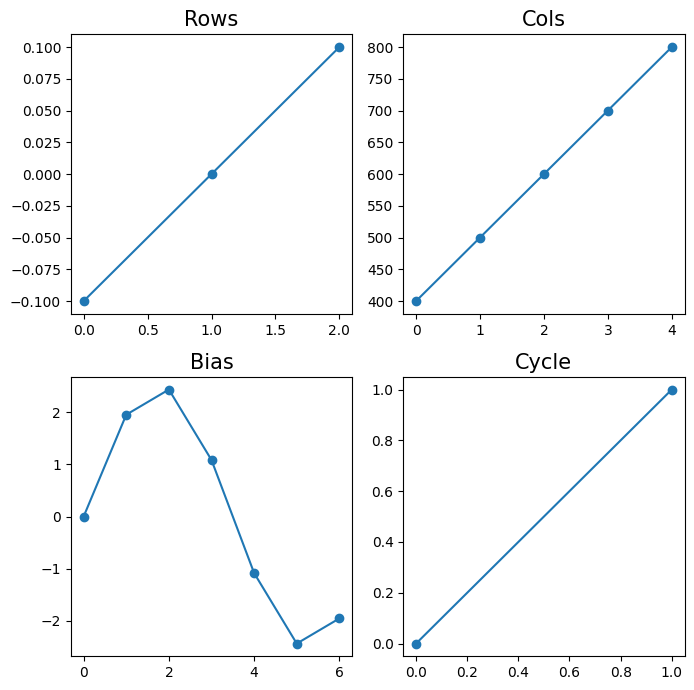

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 7))
for axis, vals, dim_name in zip(axes.flat, [rows_vals, cols_vals, bias_vals, cycle_vals],
                                ['Rows', 'Cols', 'Bias', 'Cycle']):
    axis.set_title(dim_name, fontsize=15)
    axis.plot(vals, 'o-')
fig.tight_layout()

In the USID model, position and spectroscopic dimensions are defined using some basic information that will be
incorporated in **Dimension** objects that contain three vial pieces of information:

* Name of the dimension
* units for the dimension
* values:
    * These can be the actual values over which the dimension was varied
    * or number of steps in case of linearly varying dimensions such as ``Cycle`` below

Note that the Dimension objects in the lists for Positions and Spectroscopic must be arranged from fastest varying to
slowest varying to mimic how the data is actually arranged. For example, in this example, there are multiple
bias points per cycle and multiple columns per row of data. Thus, the ``Bias`` changes faster than the ``Cycle`` and
the columns change faster than the rows. Therefore, the  ``Cols`` must come before the ``Rows`` and ``Bias`` must precede
the ``Cycle`` dimension:



In [17]:
pos_dims = [usid.Dimension('Cols', 'nm', cols_vals),
            usid.Dimension('Rows', 'um', rows_vals)]
spec_dims = [usid.Dimension('Bias', 'V', bias_vals),
             usid.Dimension('Cycle', '', num_cycles)]

## write_main_dataset()

Often, data is is recorded (from instruments) or generated (as a result of some analysis) in chunks (for example - one
position at a time). Therefore, it makes sense to first create an empty dataset and then fill in the data as it is
generated / recorded.

We will only create an empty dataset first by specifying how large the dataset should be and of what data type
(specified using the ``dtype`` keyword argument). Later, we will go over examples where the whole data is available when
creating the HDF5 dataset. The ``write_main_dataset()`` is **one of the most important and popularly used functions** in
``hdf_utils`` since it handles:

* thorough validation of all inputs
* the creation of the central dataset
* the creation of the ancillary datasets (if necessary)
* linking the ancillary datasets such that the central dataset becomes a ``Main`` dataset
* writing attributes

By default h5py does not appear to compress datasets and datasets (especially ``Main`` datasets) can balloon in size
if they are not compressed. Therefore, it is recommended that the compression keyword argument is passed as well.
``gzip`` is the compression algorithm that is always available with h5py and it does a great job, so we will use this.

We could use the ``write_simple_attrs()`` function to write attributes to ``Raw_Data`` at a later stage but we can always
pass these attributes to be written at the time of dataset creation if they are already known



In [18]:
h5_raw = usid.hdf_utils.write_main_dataset(h5_meas_group,  # parent HDF5 group
                                           (num_rows * num_cols, bias_pts * num_cycles),  # shape of Main dataset
                                           'Raw_Data',  # Name of main dataset
                                           'Current',  # Physical quantity contained in Main dataset
                                           'nA',  # Units for the physical quantity
                                           pos_dims,  # Position dimensions
                                           spec_dims,  # Spectroscopic dimensions
                                           dtype=np.float32,  # data type / precision
                                           compression='gzip',
                                           main_dset_attrs={'IO_rate': 4E+6, 'Amplifier_Gain': 9})
print(h5_raw)

<HDF5 dataset "Raw_Data": shape (15, 14), type "<f4">
located at: 
	/Measurement_000/Raw_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	Rows - size: 3 
	Cols - size: 5 
Spectroscopic Dimensions: 
	Cycle - size: 2 
	Bias - size: 7
Data Type:
	float32


/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer creates'


Let us take a look at the contents of the file again using the ``print_tree()`` function. What we see is that five new
datasets have been created:

* ``Raw_Data`` was created to contain the 4D measurement we are interested in storing.
* ``Spectroscopic_Indices`` and Spectroscopic_Values`` contain the information about the spectroscopic dimensions
* ``Position_Indices`` and ``Position_Values`` contain the position related information

The underline below ``Measurement_000`` indicates that this is a HDF5 Group



In [19]:
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


As mentioned in our `document about the USID
model <../../data_format.html>`, the four supporting datasets (``Indices`` and
``Values`` datasets for ``Position`` and ``Spectroscopic``) help provide meaning to each element in ``Raw_Data`` such as
dimensionality, etc.

Only ``Raw_Data`` is a ``USID Main dataset`` while all other datasets are just supporting datasets. We can
verify whether a dataset is a Main dataset or not using the ``check_if_main()`` function:



In [20]:
for dset in [h5_raw, h5_raw.h5_spec_inds, h5_raw.h5_pos_vals]:
    print('Is {} is a Main dataset?: {}'.format(dset.name, usid.hdf_utils.check_if_main(dset)))

Is /Measurement_000/Raw_Data is a Main dataset?: True
Is /Measurement_000/Spectroscopic_Indices is a Main dataset?: False
Is /Measurement_000/Position_Values is a Main dataset?: False


## Populating the Dataset:

Note that h5_main still does not contain the values we are interested in filling it in with:



In [21]:
print(h5_raw[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Let us simulate a situation where we are recording the data a pixel at a time and writing it to the h5_main dataset:



In [22]:
source_main_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

for pixel_ind, pixel_data in enumerate(source_main_data):
    h5_raw[pixel_ind] = pixel_data

# Make sure to ``flush`` the file (write anything in the buffer into the file)
h5_file.flush()

Note that we were only simulating a (realistic) situation where all the data was not present at once to write into
``Raw_Data`` dataset. Let us check the contents at a particular position in the dataset now:



In [23]:
print(h5_raw[5])

[0.57908833 0.6056317  0.57019556 0.79568505 0.89794546 0.5628234
 0.36636862 0.49692482 0.07369512 0.89194983 0.87636715 0.68721926
 0.04470357 0.20441724]


## Exploring attributes in Main datasets:

Some of the main requirements for promoting a regular dataset to a Main dataset are some mandatory attributes attached
to the dataset:

* quantity - What the stored data contains - for example: current, temperature, voltage, strain etc.
* units - the units for the quantity, such as Amperes, meters, etc.
* links to each of the four ancillary datasets

Again, we can use the ``get_attributes()`` function to see if and how these attributes are stored:



In [24]:
for key, val in sidpy.hdf_utils.get_attributes(h5_raw).items():
    print('{} : {}'.format(key, val))

Amplifier_Gain : 9
IO_rate : 4000000.0
Position_Indices : <HDF5 object reference>
Position_Values : <HDF5 object reference>
Spectroscopic_Indices : <HDF5 object reference>
Spectroscopic_Values : <HDF5 object reference>
machine_id : fv-az1691-747
platform : Linux-6.8.0-1021-azure-x86_64-with-glibc2.39
pyUSID_version : 0.0.12
quantity : Current
sidpy_version : 0.12.6
timestamp : 2025_03_07-22_01_38
units : nA


While it is straightforward to read simple attributes like ``quantity`` or ``units``, the values for ``Position_Values`` or
``Spectroscopic_Indices`` attributes seem cryptic. These are just references or links to other datasets.



In [25]:
print(sidpy.hdf_utils.get_attr(h5_raw, 'Position_Indices'))

<HDF5 object reference>


### Object references as attributes
We can get access to linked datasets using ``get_auxiliary_datasets()``:



In [26]:
print(sidpy.hdf_utils.get_auxiliary_datasets(h5_raw, 'Position_Indices'))

[<HDF5 dataset "Position_Indices": shape (15, 2), type "<u4">]


Given that ``h5_raw`` is a ``Main`` dataset, and`` Position_Indices`` is one of the four essential components of a ``Main``
dataset, the ``USIdataset`` object makes it far easier to access the ``ancillary datasets`` without needing to call a
function as above.
`The USIDataset class <./plot_usi_dataset.html>`_
has been discussed in greater detail in a separate document.

What do we do if we need to store some other supporting information regarding some measurement? If such supporting
datasets do not need to be ``USID Main datasets``, we could simply use the basic functionality of ``h5py`` to create
the dataset



In [27]:
h5_other = h5_meas_group.create_dataset('Other', np.random.rand(5))

h5USID files tend to have a fair number of datasets in them and the most important ones are ``Main datasets`` and
users tend to "walk" or "hop" through the file by stepping only on the ``Main datasets``. Thus, we often want to link
supporting datasets to the relevant ``Main datasets``. This way, such supporting datasets can be accessed via an
attribute of the ``Main dataset`` instead of having to manually specify the path of the supporting dataset.

## link_h5_objects_as_attrs()
``link_h5_objects_as_attrs()`` makes it easy to link a dataset or group to any other dataset or group. In this example
we will link the ``Other`` dataset to the ``Raw_Data`` dataset:



In [28]:
sidpy.hdf_utils.link_h5_objects_as_attrs(h5_raw, h5_other)

for key, val in sidpy.hdf_utils.get_attributes(h5_raw).items():
    print('{} : {}'.format(key, val))

Amplifier_Gain : 9
IO_rate : 4000000.0
Other : <HDF5 object reference>
Position_Indices : <HDF5 object reference>
Position_Values : <HDF5 object reference>
Spectroscopic_Indices : <HDF5 object reference>
Spectroscopic_Values : <HDF5 object reference>
machine_id : fv-az1691-747
platform : Linux-6.8.0-1021-azure-x86_64-with-glibc2.39
pyUSID_version : 0.0.12
quantity : Current
sidpy_version : 0.12.6
timestamp : 2025_03_07-22_01_38
units : nA


In the same way, we can even link a group to the ``Other`` dataset:



In [29]:
sidpy.hdf_utils.link_h5_objects_as_attrs(h5_other, h5_some_group)

for key, val in sidpy.hdf_utils.get_attributes(h5_other).items():
    print('{} : {}'.format(key, val))

Some_Group : <HDF5 object reference>


What we see above is that 'Other' is now an attribute of the 'Raw_Data' dataset.

One common scenario in scientific workflows is the storage of multiple ``Main Datasets`` within the same group. The
first ``Main dataset`` can be stored along with its four ``ancillary datasets`` without any problems. However, if the
second ``Main dataset`` also requires the storage of ``Position`` and ``Spectroscopic`` datasets, these datasets would need
to be named differently to avoid conflicts with existing datasets (associated with the first ``Main dataset``). Moreover
, these ``ancillary datasets`` would need to be linked to the second ``Main dataset`` with the standard ``Position_..`` and
``Spectroscopic_..`` names for the attributes.

## link_h5_obj_as_alias()
``link_h5_obj_as_alias()`` is handy in this scenario since it allows a dataset or group to be linked with a name
different from its actual name. For example, we can link the ``Raw_Data`` dataset to the ``Other`` dataset with an alias:



In [30]:
sidpy.hdf_utils.link_h5_obj_as_alias(h5_other, h5_raw, 'Mysterious_Dataset')

for key, val in sidpy.hdf_utils.get_attributes(h5_other).items():
    print('{} : {}'.format(key, val))

Mysterious_Dataset : <HDF5 object reference>
Some_Group : <HDF5 object reference>


The dataset named ``Other`` has a new attribute named ``Mysterious_Dataset``. Let us show that this dataset is none other
than ``Raw_Data``:



In [31]:
h5_myst_dset = sidpy.hdf_utils.get_auxiliary_datasets(h5_other, 'Mysterious_Dataset')[0]
print(h5_myst_dset == h5_raw)

True


### Processing on Datasets
Lets assume that we are normalizing the data in some way and we need to write the results back to the file. As far
as the data shapes and dimensionality are concerned, let us assume that the data still remains a 4D dataset.

## create_results_group()
Let us first start off with creation of a HDF5 Group that will contain the results. If you recall, groups that contain
the results of some processing / analysis on a source dataset are named as ``Source_Dataset_name-Process_Name_00x``
where the index of the group. The ``create_results_group()`` function makes it very easy to create a group with such
nomenclature and indexing:



In [32]:
h5_results_group_1 = sidpy.prov_utils.create_results_group(h5_raw, 'Normalization')
print(h5_results_group_1)

<HDF5 group "/Measurement_000/Raw_Data-Normalization_000" (0 members)>


/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/sidpy/hdf/prov_utils.py:122: FutureWarning: The behavior of create_results_group is very likely to change soon and significantly. Use this function with caution
  warn('The behavior of create_results_group is very likely to change soon '


Let us make up some (random) data which is the result of some Normalization on the ``Raw_Data``:



In [33]:
norm_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

## Writing the main dataset
In this scenario we will demonstrate how one might write a ``Main dataset`` when having the complete processed (in this
case some normalization) data is available before even creating the dataset.

One more important point to remember here is that the normalized data is of the same shape and dimensionality as
``Raw_Data``. Therefore, we need not unnecessarily create ancillary datasets - we can simply refer to the ones that
support ``Raw_Data``. During the creation of ``Raw_Data``, we passed the ``pos_dims`` and ``spec_dims`` parameters for the
creation of new ``Ancillary datasets``. In this case, we will show how we can ask ``write_main_dataset()`` to reuse
existing ancillary datasets:



In [34]:
h5_norm = usid.hdf_utils.write_main_dataset(h5_results_group_1,  # parent group
                                            norm_data,  # data to be written
                                            'Normalized_Data',  # Name of the main dataset
                                            'Current',  # quantity
                                            'nA',  # units
                                            None,  # position dimensions
                                            None,  # spectroscopic dimensions
                                            h5_pos_inds=h5_raw.h5_pos_inds,
                                            h5_pos_vals=h5_raw.h5_pos_vals,
                                            h5_spec_inds=h5_raw.h5_spec_inds,
                                            h5_spec_vals=h5_raw.h5_spec_vals,
                                            compression='gzip')
print(h5_norm)

<HDF5 dataset "Normalized_Data": shape (15, 14), type "<f8">
located at: 
	/Measurement_000/Raw_Data-Normalization_000/Normalized_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	Rows - size: 3 
	Cols - size: 5 
Spectroscopic Dimensions: 
	Cycle - size: 2 
	Bias - size: 7
Data Type:
	float64


When we look at the contents of hte file again, what we see below is that the newly created group
``Raw_Data-Normalization_000`` only contains the ``Normalized_Data`` dataset and none of the supporting ancillary datasets
since it is sharing the same ones created for ``Raw_Data``



In [35]:
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Other
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Raw_Data-Normalization_000
    --------------------------
    ├ Normalized_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


## Shared ancillary datasets
Let us verify that ``Raw_Data`` and ``Normalized_Data`` share the same ancillary datasets:



In [36]:
for anc_name in ['Position_Indices', 'Position_Values', 'Spectroscopic_Indices', 'Spectroscopic_Values']:
    # get the handle to the ancillary dataset linked to 'Raw_Data'
    raw_anc = sidpy.hdf_utils.get_auxiliary_datasets(h5_raw, anc_name)[0]
    # get the handle to the ancillary dataset linked to 'Normalized_Data'
    norm_anc = sidpy.hdf_utils.get_auxiliary_datasets(h5_norm, anc_name)[0]
    # Show that these are indeed the same dataset
    print('Sharing {}: {}'.format(anc_name, raw_anc == norm_anc))

Sharing Position_Indices: True
Sharing Position_Values: True
Sharing Spectroscopic_Indices: True
Sharing Spectroscopic_Values: True


Unlike last time with ``Raw_Data``, we wrote the data to the file when creating ``Normalized_Data``, so let us check to
make sure that we did in fact write data to disk:



In [37]:
print(h5_norm[5])

[0.22243748 0.85410151 0.36777127 0.35073979 0.70137897 0.61189659
 0.22555967 0.8254328  0.65935789 0.07469833 0.11941909 0.54513098
 0.29453888 0.83206956]


### Duplicating Datasets

## create_empty_dataset()
Let us say that we are interested in writing out another dataset that is again of the same shape and dimensionality as
``Raw_Data`` or ``Normalized_Data``. There is another way to create an empty dataset identical to an existing dataset,
and then fill it in. This approach is an alternative to the approach used for ``Normalized_Data``:



In [38]:
h5_offsets = usid.hdf_utils.create_empty_dataset(h5_norm, np.float32, 'Offsets')
print(h5_offsets)

<HDF5 dataset "Offsets": shape (15, 14), type "<f4">
located at: 
	/Measurement_000/Raw_Data-Normalization_000/Offsets 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	Rows - size: 3 
	Cols - size: 5 
Spectroscopic Dimensions: 
	Cycle - size: 2 
	Bias - size: 7
Data Type:
	float32


In this very specific scenario, we duplicated practically all aspects of ``Normalized_Data``, including its links to the
ancillary datasets. Thus, this ``h5_offsets`` automatically also becomes a ``Main dataset``.

However, it is empty and needs to be populated



In [39]:
print(h5_offsets[6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Since this is an example, we will populate the dataset using same data prepare for ``norm_data``



In [40]:
h5_offsets[()] = norm_data
print(h5_offsets[6])

[0.4262138  0.7230509  0.0779063  0.77554876 0.55999863 0.5518511
 0.22364023 0.61883676 0.04049517 0.8936019  0.25699493 0.94809175
 0.05728537 0.312141  ]


### Creating Ancillary datasets
Often, certain processing of data involves the removal of one or more dimensions (typically ``Spectroscopic``). This
necessitates careful generation of ``indices`` and ``values`` datasets. In our example, we will remove the spectroscopic
dimension - ``Bias`` and leave the position dimensions as is. While we could simply regenerate the spectroscopic indices
from scratch knowing that the only remaining spectroscopic dimension is ``Cycle``, this is not feasible when writing
robust code where we have minimal control or knowledge about the other dimensions. This is especially true when there
are 3 or more spectroscopic dimensions and we do not know relationships between the spectroscopic dimensions or the
rates of change in these spectroscopic dimensions. Fortunately, ``hdf_utils.write_reduced_spec_dsets()`` substantially
simplifies this problem as shown below.

First, we still need to create the results HDF5 group to hold the results:



In [41]:
h5_analysis_group = sidpy.prov_utils.create_results_group(h5_norm, 'Fitting')

Let us take a look at the contents of the HDF5 file again. Clearly, we do not have any new datasets underneath
``Normalized_Data-Fitting_000``



In [42]:
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Other
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Raw_Data-Normalization_000
    --------------------------
    ├ Normalized_Data
    ├ Normalized_Data-Fitting_000
      ---------------------------
    ├ Offsets
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


## write_reduced_anc_dsets()
Now we make the new spectroscopic indices and values datasets while removing the ``Bias`` dimension using the
``write_reduced_anc_dsets()`` function. This is especially useful when performing dimensionality reduction
statistically (machine learning / simpler methods such as averaging) or by fitting a dimension to some functional form



In [43]:
h5_spec_inds, h5_spec_vals = usid.hdf_utils.write_reduced_anc_dsets(h5_analysis_group,
                                                                    h5_norm.h5_spec_inds,
                                                                    h5_norm.h5_spec_vals,
                                                                    'Bias', is_spec=True)
print(h5_spec_inds)

<HDF5 dataset "Spectroscopic_Indices": shape (1, 2), type "<u4">


Let us take a look at the contents only inside h5_analysis_group now. Clearly, we have created two new spectroscopic
ancillary datasets.



In [44]:
sidpy.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Spectroscopic_Indices
├ Spectroscopic_Values


## write_ind_val_dsets()
Similar to ``write_reduced_spec_dsets()``, ``hdf_utils`` also has another function called ``write_ind_val_dsets()`` that is
handy when one needs to create the ancillary datasets before ``write_main_dataset()`` is called. For example, consider a
data processing algorithm that may or may not change the position dimensions. You may need to structure your code this
way:

.. code-block:: python

    if position dimensions are unchanged:
      # get links to datasets from the source dataset
      h5_pos_inds, h5_pos_vals = h5_source.h5_pos_inds, h5_source.h5_pos_vals
    else:
      # Need to create fresh HDF5 datasets
      h5_pos_inds, h5_pos_vals = write_ind_val_dsets()

    # At this point, it does not matter how we got h5_pos_inds, h5_pos_vals. We can simply link them when we
    # create the main dataset.
    h5_new_main = write_main_dataset(...., h5_pos_inds=h5_pos_inds, h5_pos_vals=h5_pos_vals)

Even though we already decided that we would not be changing the position dimensions for this particular example, we
will demonstrate the usage of ``write_ind_val_dsets()`` to make ``position indices`` and ``values`` HDF5 datasets (that are
identical to the ones already linked to ``h5_norm``)



In [45]:
h5_pos_inds, h5_pos_vals = usid.hdf_utils.write_ind_val_dsets(h5_analysis_group, pos_dims, is_spectral=False)

Looking at the contents of ``Normalized_Data-Fitting_000`` now reveals that we have added the ``Position`` datasets as
well. However, we still do not have the ``Main dataset``.



In [46]:
sidpy.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Position_Indices
├ Position_Values
├ Spectroscopic_Indices
├ Spectroscopic_Values


Finally, we can create and write a Main dataset with some results using the trusty write_main_dataset function. Since
we have created both the Spectroscopic and Position HDF5 dataset pairs, we simply ask write_main_dataset() to re-use
+ link them. This is why the ``pos_dims`` and ``spec_dims`` arguments are None (we don't want to create new datasets).



In [47]:
reduced_main = np.random.rand(num_rows * num_cols, num_cycles)
h5_cap_1 = usid.hdf_utils.write_main_dataset(h5_analysis_group,  # parent HDF5 group
                                           reduced_main,  # data for Main dataset
                                           'Capacitance',  # Name of Main dataset
                                           'Capacitance',  # Quantity
                                           'pF',  # units
                                           None,  # position dimensions
                                           None,  # spectroscopic dimensions
                                           h5_spec_inds=h5_spec_inds,
                                           h5_spec_vals=h5_spec_vals,
                                           h5_pos_inds=h5_pos_inds,
                                           h5_pos_vals=h5_pos_vals,
                                             compression='gzip')
print(h5_cap_1)

<HDF5 dataset "Capacitance": shape (15, 2), type "<f8">
located at: 
	/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000/Capacitance 
Data contains: 
	Capacitance (pF) 
Data dimensions and original shape: 
Position Dimensions: 
	Rows - size: 3 
	Cols - size: 5 
Spectroscopic Dimensions: 
	Cycle - size: 2
Data Type:
	float64


### Multiple Main Datasets
Let's say that we need to create a new ``Main dataset`` within the same folder as ``Capacitance`` called
``Mean_Capacitance``. ``Mean_Capacitance`` would just be a spatial map with average capacitance, so it would not even have
the ``Cycle`` spectroscopic dimension. This means that we can reuse the newly created ``Position ancillary datasets`` but
we would need to create new ``Spectroscopic_Indices`` and ``Spectroscopic_Values`` datasets in the same folder to express
the 0 dimensions in the spectroscopic axis for this new dataset. However, we already have datasets of this name that
we created above using the ``write_reduced_spec_dsets()`` function. Recall, that the criterion for a ``Main dataset`` is
that it should have attributes of name ``Spectroscopic_Indices`` and ``Spectroscopic_Values``. **It does not matter what
the actual name of the linked datasets are**. Coming back to the current example, we could simply ask
``write_main_dataset()`` to name the spectroscopic datasets with a different prefix - ``Empty_Spec`` instead of
``Spectroscopic`` (which is the default) via the ``aux_spec_prefix`` keyword argument (last line). This allows the
creation of the new Main Dataset without any name clashes with existing datasets:



In [48]:
h5_cap_2 = usid.hdf_utils.write_main_dataset(h5_analysis_group,  # Parent HDF5 group
                                           np.random.rand(num_rows * num_cols, 1),  # Main Data
                                           'Mean_Capacitance',  # Name of Main Dataset
                                           'Capacitance',  # Physical quantity
                                           'pF',  # Units
                                           None,  # Position dimensions
                                           usid.Dimension('Capacitance', 'pF', 1),  # Spectroscopic dimensions
                                           h5_pos_inds=h5_pos_inds,
                                           h5_pos_vals=h5_pos_vals,
                                           aux_spec_prefix='Empty_Spec')
print(h5_cap_2)

<HDF5 dataset "Mean_Capacitance": shape (15, 1), type "<f8">
located at: 
	/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000/Mean_Capacitance 
Data contains: 
	Capacitance (pF) 
Data dimensions and original shape: 
Position Dimensions: 
	Rows - size: 3 
	Cols - size: 5 
Spectroscopic Dimensions: 
	Capacitance - size: 1
Data Type:
	float64


The ``compression`` argument need not be specified for small datasets such as ``Mean Capacitance``.
Clearly, ``Mean_Capacitance`` and ``Capacitance`` are two ``Main datasets`` that coexist in the same HDF5 group along
with their necessary ancillary datasets.

Now, let us look at the contents of the group: ``Normalized_Data-Fitting_000`` to verify this:



In [49]:
sidpy.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Capacitance
├ Empty_Spec_Indices
├ Empty_Spec_Values
├ Mean_Capacitance
├ Position_Indices
├ Position_Values
├ Spectroscopic_Indices
├ Spectroscopic_Values


### File status
is_editable_h5()
------------------
When writing a class or a function that modifies or adds data to an existing HDF5 file, it is a good idea to check to
make sure that it is indeed possible to write the new data to the file. ``is_editable_h5()`` is a handy function for
this very purpose:



In [50]:
print('Is the file editable?: {}'.format(sidpy.hdf_utils.is_editable_h5(h5_file)))

Is the file editable?: True


If we close the file and try again we should expect runtime and Value errors. You can try this by yourself if you like



In [51]:
h5_file.close()
# print('Is the file editable?: {}'.format(sidpy.hdf_utils.is_editable_h5(h5_file)))

Let us try again by opening this file in read-only mode. We should see that the file will not be editable:



In [52]:
h5_file = h5py.File('test.h5', mode='r')
print('Is the file editable?: {}'.format(sidpy.hdf_utils.is_editable_h5(h5_file)))

Is the file editable?: False


Closing and deleting the file



In [53]:
h5_file.close()
os.remove(file_path)